<a href="https://colab.research.google.com/github/jmolins89/final-project/blob/master/New_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

# Loading data ...

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
categories=['NORMAL','PNEUMONIA']
IMG_SIZE=200

def create_training_data(datadir,IMG_SIZE):
    '''
    '''
    lst=[]
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        path = os.path.join(datadir, category)  # path to normal or pneumonia
        class_num=categories.index(category)    # Set category by index in categories: 0 -> Normal, 1 -> Pneumonia
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   # read the original image
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizes the original image to a IMG_SIZE
                lst.append([new_array,class_num])     # Appends to the list a tuple with array resized and each label
            except Exception as e:
                pass
    return lst

training_data = create_training_data('/content/drive/My Drive/chest_xray/train',200)
test_data = create_training_data('/content/drive/My Drive/chest_xray/test',200)
validation_data = create_training_data('/content/drive/My Drive/chest_xray/val',200)

KeyboardInterrupt: ignored

In [0]:
random.shuffle(training_data)
random.shuffle(test_data)
random.shuffle(validation_data)

In [0]:
def createxy(data):
    X,y=[],[]
    for features,label in data:
        X.append(features/255)
        y.append(label)
    return X,y

X_train,y_train = createxy(training_data)
X_test,y_test = createxy(test_data)
X_val,y_val = createxy(validation_data)

In [0]:
X_train=np.array(X_train).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test=np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val=np.array(X_val).reshape(-1,IMG_SIZE,IMG_SIZE,1)


# Exporting arrays with images and labels

In [0]:
import pickle

pickle_out = open('X_train.pickle','wb')
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open('y_train.pickle','wb')
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open('X_test.pickle','wb')
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open('y_test.pickle','wb')
pickle.dump(y_test, pickle_out)
pickle_out.close()

pickle_out = open('X_val.pickle','wb')
pickle.dump(X_val, pickle_out)
pickle_out.close()

pickle_out = open('y_val.pickle','wb')
pickle.dump(y_val, pickle_out)
pickle_out.close()

In [0]:
import pickle
pickle_in1=open('/content/drive/My Drive/X_train.pickle','rb')
pickle_in2=open('/content/drive/My Drive/y_train.pickle','rb')
pickle_in3=open('/content/drive/My Drive/X_test.pickle','rb')
pickle_in4=open('/content/drive/My Drive/y_test.pickle','rb')
pickle_in5=open('/content/drive/My Drive/X_val.pickle','rb')
pickle_in6=open('/content/drive/My Drive/y_val.pickle','rb')

X_train,y_train=pickle.load(pickle_in1),pickle.load(pickle_in2)
X_test,y_test=pickle.load(pickle_in3),pickle.load(pickle_in4)
X_val,y_val=pickle.load(pickle_in5),pickle.load(pickle_in6)

In [9]:
len(X_train)

5216

In [10]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.callbacks import TensorBoard
from time import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import ReLU
import imageio
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


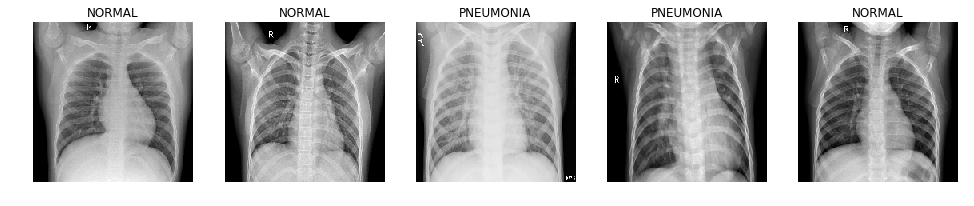

In [11]:
dic={0:'NORMAL',1:'PNEUMONIA'}
plt.figure(figsize=(20,12))
for index,img in enumerate(X_train[:5]):  
    plt.subplot(1,6,index+1)
    plt.imshow(img.reshape(200,200), cmap='gray')
    plt.axis('off')
    plt.title(dic.get(y_train[index]))
plt.show()

In the previous images **we can't distinguish the normal case with the pneumonia** if we are not a doctor.

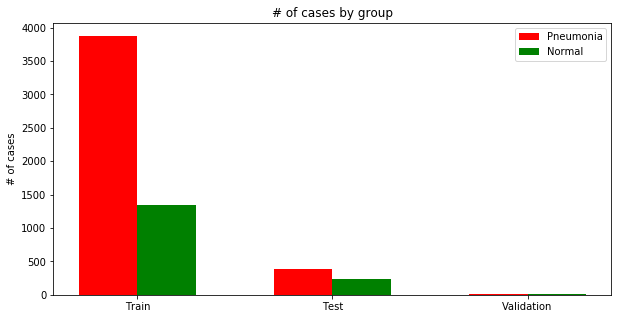

In [12]:
N = 3
normal=(y_train.count(0),y_test.count(0),y_val.count(0))
pneumonia=(y_train.count(1),y_test.count(1),y_val.count(1))
ind = np.arange(N)    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(10,5))
p1 = plt.bar(ind-0.15, pneumonia, width,color='r')
p2 = plt.bar(ind+0.15, normal, width, color='g')
plt.ylabel('# of cases')
plt.title('# of cases by group')
plt.xticks(ind, ('Train', 'Test', 'Validation'))
plt.yticks(np.arange(0, 4500, 500))
plt.legend((p1[0], p2[0]), ('Pneumonia','Normal'))

plt.show()



In the previous graph we can observe that **the data is unbalanced**, because we have more Pneumonia cases than Normal.

We have to **rebalance** the data to train better a neural network.

We are going to use the SMOTE method to generate random images between normal ones.



In [0]:
np.bincount(y_train)

array([1341, 3875])

In [0]:
print('{} normal cases to create for train data'.format(np.bincount(y_train)[1]-np.bincount(y_train)[0]))
print('{} normal cases to create for test data'.format(np.bincount(y_test)[1]-np.bincount(y_test)[0]))
print('{} normal cases to create for validation data'.format(np.bincount(y_val)[1]-np.bincount(y_val)[0]))

2534 normal cases to create for train data
156 normal cases to create for test data
0 normal cases to create for validation data


In [0]:
sm = SMOTE(random_state=42)

In [0]:
#from imblearn.over_sampling import SMOTE

#def makeOverSamplesSMOTE(X,y):
#    sm = SMOTE()
#    X, y = sm.fit_sample(X, y)
#    return X,y
#X_train_resampled, y_train_resampled = makeOverSamplesSMOTE(X_train, y_train)

## **Creando generador imágenes**

In [0]:
def image_gen(img_paths, img_size=(128, 128)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.jpeg')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) / 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

# Convolutional Neural Network

In [0]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
y_val_binary = to_categorical(y_val)

In [59]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(200, 200,1), activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',  # we train 2-way classification
    optimizer=keras.optimizers.Adadelta(),  # for SGD
    metrics=['accuracy'],  # report accuracy during training
    #shuffle=True,
    #verbose=1
)
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
modeltrain = model.fit(x=X_train,y=y_train_binary, epochs=30,#,callbacks=[tensorboard])#,
                   validation_data = (X_val,y_val_binary), batch_size=128)

Train on 5216 samples, validate on 16 samples
Epoch 1/300
5216/5216 [==============================] - 18s 3ms/step - loss: 0.6099 - acc: 0.7385 - val_loss: 0.7523 - val_acc: 0.5000
Epoch 2/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.5621 - acc: 0.7483 - val_loss: 0.7719 - val_acc: 0.5000
Epoch 3/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.4743 - acc: 0.7799 - val_loss: 0.8958 - val_acc: 0.5625
Epoch 4/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.3412 - acc: 0.8702 - val_loss: 1.1430 - val_acc: 0.5625
Epoch 5/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.2343 - acc: 0.9080 - val_loss: 0.7727 - val_acc: 0.6250
Epoch 6/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.1714 - acc: 0.9337 - val_loss: 0.5492 - val_acc: 0.6875
Epoch 7/300
5216/5216 [==============================] - 17s 3ms/step - loss: 0.1516 - acc: 0.9463 - val_loss: 0.5096 - val_acc: 0.6875
Ep

In [19]:
modeltrain.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

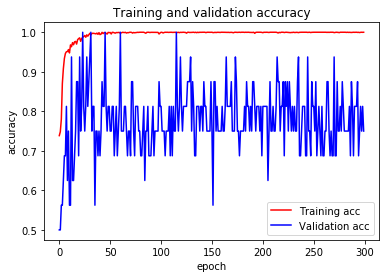

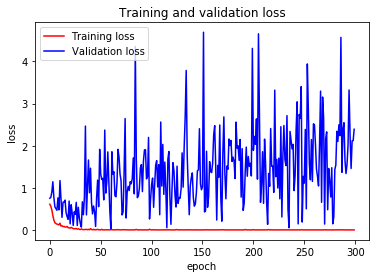

In [60]:
#Graphing our training and validation
acc = modeltrain.history['acc']
val_acc = modeltrain.history['val_acc']
loss = modeltrain.history['loss']
val_loss = modeltrain.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [61]:
val_loss,val_acc = model.evaluate(X_test,y_test_binary)
print(val_loss,val_acc)

624/624 [==============================] - 1s 1ms/step
3.5681928793589273 0.7548076923076923


In [0]:
predictions=model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_binary.argmax(axis=1), predictions.argmax(axis=1))


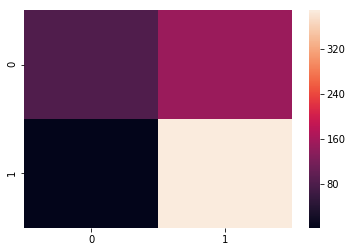

In [64]:
import seaborn as sns
sns.heatmap(matrix);

In [65]:
matrix

array([[ 83, 151],
       [  2, 388]])

In [0]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)#, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


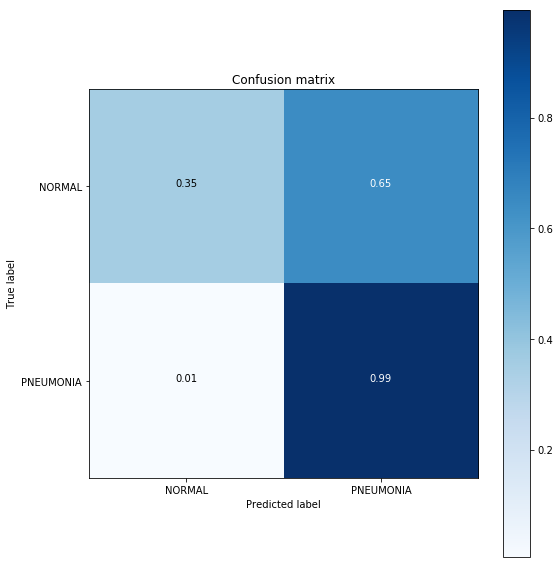

In [67]:
preds = np.argmax(model.predict(X_test), axis = 1)
cm = confusion_matrix([np.argmax(i) for i in y_test_binary],preds)
keys = ['NORMAL','PNEUMONIA']
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)